In [17]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import os

In [2]:
video_name = 'Help'
data = pd.read_fwf('data/head_tracking_data/Subject_6/' + video_name + '.txt', header=None)

data.columns = ['latitude', 'longitude']

cap = cv2.VideoCapture('data/video_files/' + video_name + '.mp4')

# Get video meta data
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Calculate pixels per degree
width_normalized = width/360
height_normalized = height/180

# Calculate FoV offsets, 110 degrees horizontal, 100 degrees verti
width_offset = width_normalized*55
height_offset = height_normalized*50

calc_mod = round(1/(round((length/len(data)),2)-1))

The next code block can probably be simplified since currently:

~~~
long/lat -> x/y -> x/y start and end points -> long/lat start and end points -> UTM coordinates
~~~

So basically, we can just calculate start and end from lat long directly, this will take out 2 steps

In [3]:
def conversion(lat, lon):
    x = (180 - lon) * width_normalized
    y = (90 - lat) * height_normalized
    return(x, y)

def start_end_point(x, y):
    start_point = (int(x - width_offset), int(y + height_offset))
    end_point = (int(x + width_offset), int(y - height_offset))
    return(start_point, end_point)

# The if/elif statements are there to wrap the viewport around the edge of the screen
# aka a location of 181, is the same as -179.
def back_conv(x, y):
    lon = 180 - (x/width_normalized)
    if lon > 180: lon -= 360
    elif lon < -180: lon += 360
    lat = 90 - (y/height_normalized)
    if lat > 80: lat -= 160
    elif lat < -80: lat += 160
    return(lat, lon)

starting_points = []
ending_points = []

# Determine top left and bottom right UTM coordinates of the viewport
for i in range(len(data)):
    x,y = conversion(data.iloc[i]['latitude'], data.iloc[i]['longitude'])
    start_point, end_point = start_end_point(x, y)

    start = back_conv(start_point[0], start_point[1])
    end = back_conv(end_point[0], end_point[1])
    
    u1 = utm.from_latlon(start[0], start[1])
    starting_points.append(u1[2:])
    
    u2 = utm.from_latlon(end[0], end[1])
    ending_points.append(u2[2:])

starting_zones = pd.DataFrame(starting_points)
ending_zones = pd.DataFrame(ending_points)

In [4]:
# concatenate zones and zone bands to dataframe
coords = pd.concat([data, starting_zones, ending_zones],axis=1)
coords.columns = ['latitude', 'longitude', 's_zone', 's_band', 'e_zone', 'e_band']

In [5]:
# convert band-letters to numbers - issue exists because mercator zones omit the letters "I" and "O"
coords['ns_band'] = [ ord(x) - 64 for x in coords.s_band ]
coords['ne_band'] = [ ord(x) - 64 for x in coords.e_band ]

In [6]:
# Probably here we can work out the size of a tile
# Determine bins (for 4x4 tiling it will be 15 UTM zones and 6 UTM bands)
bins_zone = [i*15 for i in range(0,5)]
labels_zone = [i for i in range(1,5)]

bins_band = [i*6 for i in range(0,5)]
labels_band = [i for i in range(1,5)]

# Binning results
coords['s_bin_zone'] = pd.DataFrame(pd.cut(coords['s_zone'], bins=bins_zone, labels=labels_zone))
coords['s_bin_band'] = pd.DataFrame(pd.cut(coords['ns_band'], bins=bins_band, labels=labels_band))
coords['e_bin_zone'] = pd.DataFrame(pd.cut(coords['e_zone'], bins=bins_zone, labels=labels_zone))
coords['e_bin_band'] = pd.DataFrame(pd.cut(coords['ne_band'], bins=bins_band, labels=labels_band))

In [7]:
G = nx.DiGraph()
for i in range(len(coords)-1):

    prev_top_left_zone = (coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band'])
    prev_bottom_right_zone = (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])
    curr_top_left_zone = (coords.iloc[i+1]['s_bin_zone'], coords.iloc[i+1]['s_bin_band'])
    curr_bottom_right_zone = (coords.iloc[i+1]['e_bin_zone'], coords.iloc[i+1]['e_bin_band'])

    # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
    G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone))
    

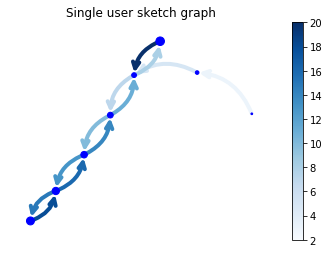

In [16]:
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    connectionstyle="arc3,rad=0.3",
    width=4,
)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('Single user sketch graph')
plt.show()


In [9]:
# Check whether amount of nodes corresponds with the amount of unique views in a data set
lst = []
for i in range(len(coords)):
    lst.append(((coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band']), (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])))

df = pd.DataFrame(lst)
df.columns = ['starts', 'ends']

no_uniques = len(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))
no_nodes = G.number_of_nodes()

print('Valid output:', no_uniques == no_nodes)
print('No of nodes:', no_nodes)
print('No of uniques:', no_uniques)
print(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))

Valid output: True
No of nodes: 8
No of uniques: 8
   starts    ends  count
0  (2, 1)  (1, 4)     19
1  (3, 1)  (1, 4)      2
2  (3, 1)  (2, 4)     11
3  (3, 2)  (2, 4)     86
4  (4, 1)  (2, 4)      5
5  (4, 1)  (3, 4)    485
6  (4, 2)  (2, 4)      2
7  (4, 2)  (3, 4)      4


In [6]:
import pandas as pd
subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos


videos = {} # each video will contain all subjects

frames_per_segment = 30

for video_id in video_list:
    subjects = {} # for each subject, we store segments which are in seperate lists

    for subject_id in subject_list:
        tmp_data = pd.read_fwf('data/head_tracking_data/'+ subject_id + '/' + video_id.split('.mp4')[0] + '.txt', header=None)
        n_segments = int(len(tmp_data)/frames_per_segment) # ofc its not entirely coorect yet, it approximates how many segments\
        segments = []

        for seg in range(n_segments):
            # print('start ' , frames_per_segment * seg , ' end ', frames_per_segment * (seg+1))
            start = frames_per_segment * seg
            end = frames_per_segment * (seg+1)
            segments.append(tmp_data[start:end])

        subjects[subject_id] = segments

    videos[video_id] = subjects


In [9]:
videos['AcerPredator.mp4'].keys()

dict_keys(['Subject_1', 'Subject_10', 'Subject_11', 'Subject_12', 'Subject_13', 'Subject_14', 'Subject_15', 'Subject_16', 'Subject_17', 'Subject_18', 'Subject_19', 'Subject_2', 'Subject_20', 'Subject_21', 'Subject_22', 'Subject_23', 'Subject_24', 'Subject_25', 'Subject_26', 'Subject_27', 'Subject_28', 'Subject_29', 'Subject_3', 'Subject_30', 'Subject_31', 'Subject_32', 'Subject_33', 'Subject_34', 'Subject_35', 'Subject_36', 'Subject_37', 'Subject_38', 'Subject_39', 'Subject_4', 'Subject_40', 'Subject_5', 'Subject_6', 'Subject_7', 'Subject_8', 'Subject_9'])

In [11]:
videos.keys()

dict_keys(['A380.mp4', 'AcerPredator.mp4', 'AirShow.mp4', 'Antarctic.mp4', 'BFG.mp4', 'BlueWorld.mp4', 'BTSRun.mp4', 'CandyCarnival.mp4', 'CMLauncher.mp4', 'Cryogenian.mp4', 'CS.mp4', 'Dota2.mp4', 'DrivingInAlps.mp4', 'Dubai.mp4', 'Egypt.mp4', 'F5Fighter.mp4', 'GalaxyOnFire.mp4', 'Gliding.mp4', 'Graffiti.mp4', 'Help.mp4', 'HondaF1.mp4', 'IRobot.mp4', 'KasabianLive.mp4', 'LetsNotBeAloneTonight.mp4', 'LOL.mp4', 'LoopUniverse.mp4', 'MC.mp4', 'MercedesBenz.mp4', 'Parachuting.mp4', 'Pokemon.mp4', 'Predator.mp4', 'ProjectSoul.mp4', 'Rally.mp4', 'RingMan.mp4', 'RioOlympics.mp4', 'RollerCoaster.mp4', 'Skiing.mp4', 'StarryPolar.mp4', 'StarWars.mp4', 'Supercar.mp4', 'SuperMario64.mp4', 'Surfing.mp4', 'Symphony.mp4', 'Terminator.mp4', 'VRBasketball.mp4', 'WaitingForLove.mp4', 'Waterskiing.mp4', 'WesternSichuan.mp4'])